In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from math import atan

def readFile(data_file: str):
    data_file = pd.read_csv(data_file, sep="\t")
    return data_file


def reformatFile(data_file: pd.DataFrame) -> np.ndarray:
    data_file = data_file.to_numpy()
    nr_rows = len(data_file[:, 0])
    data_file_reformat = np.zeros((nr_rows, 7))
    # data_s = str(data_file[50, 0])
    # print((data_s[61:73]))
    for data_file_row in range(nr_rows):
        data_s = str(data_file[data_file_row, 0])
        data_file_reformat[data_file_row, 0] = int(float(data_s[9:17]))
        data_file_reformat[data_file_row, 1] = float(data_s[20:33])
        data_file_reformat[data_file_row, 2] = float(data_s[33:46])
        data_file_reformat[data_file_row, 3] = float(data_s[48:60])
        data_file_reformat[data_file_row, 4] = float(data_s[60:73])
        data_file_reformat[data_file_row, 5] = float(data_s[74:86])
        data_file_reformat[data_file_row, 6] = float(data_s[90:102])

    return data_file_reformat


def nodeDistanceAndOrientation(data_file: np.ndarray):
    nr_rows = len(data_file[:, 0])

    node_distance = np.zeros((nr_rows, 1))
    node_orientation = np.zeros(nr_rows)
    for data_file_row in range(0, nr_rows - 1):
        dx = (data_file[data_file_row + 1, 1] + data_file[data_file_row + 1, 4]) - (
                data_file[data_file_row, 1] + data_file[data_file_row, 4])
        dy = (data_file[data_file_row + 1, 2] + data_file[data_file_row + 1, 5]) - (
                data_file[data_file_row, 2] + data_file[data_file_row, 5])
        node_distance[data_file_row, 0] = np.sqrt(dx ** 2 + dy ** 2)
        node_orientation[data_file_row] = np.arctan(dy/dx)


    return node_distance, node_orientation


def nodeLocation(node_distances: np.ndarray) -> np.ndarray:
    node_location = np.zeros(len(node_distances[:, 0]))
    for index in range(1, len(node_distances)):
        node_location[index] = node_location[index - 1] + node_distances[index]
    return node_location


loadstep1_disp = reformatFile(readFile("Data/FEM/shell_loadstep1_disp.out"))[2:, :] # first two nodes are deleted for weird placement
loadstep2_disp = reformatFile(readFile("Data/FEM/shell_loadstep2_disp.out"))[2:, :]
loadstep3_disp = reformatFile(readFile("Data/FEM/shell_loadstep3_disp.out"))[2:, :]
loadstep4_disp = reformatFile(readFile("Data/FEM/shell_loadstep4_disp.out"))[2:, :]
loadstep5_disp = reformatFile(readFile("Data/FEM/shell_loadstep5_disp.out"))[2:, :]

loadstep1_disp_nodes, loadstep1_node_orientation = nodeDistanceAndOrientation(loadstep1_disp)
loadstep2_disp_nodes, loadstep2_node_orientation = nodeDistanceAndOrientation(loadstep2_disp)
loadstep3_disp_nodes, loadstep3_node_orientation = nodeDistanceAndOrientation(loadstep3_disp)
loadstep4_disp_nodes, loadstep4_node_orientation = nodeDistanceAndOrientation(loadstep4_disp)
loadstep5_disp_nodes, loadstep5_node_orientation = nodeDistanceAndOrientation(loadstep5_disp)

loadstep1_disp_loc = nodeLocation(loadstep1_disp_nodes)
loadstep2_disp_loc = nodeLocation(loadstep2_disp_nodes)
loadstep3_disp_loc = nodeLocation(loadstep3_disp_nodes)
loadstep4_disp_loc = nodeLocation(loadstep4_disp_nodes)
loadstep5_disp_loc = nodeLocation(loadstep5_disp_nodes)

# plt.scatter(loadstep2_disp[:, 1] + loadstep2_disp[:, 4], loadstep2_disp[:, 2] + loadstep2_disp[:, 5],
#             label="Loadstep 2")
# plt.scatter(loadstep3_disp[:, 1] + loadstep3_disp[:, 4], loadstep3_disp[:, 2] + loadstep3_disp[:, 5],
#             label="Loadstep 3")
# plt.scatter(loadstep4_disp[:, 1] + loadstep4_disp[:, 4], loadstep4_disp[:, 2] + loadstep4_disp[:, 5],
#             label="Loadstep 4")
# plt.scatter(loadstep5_disp[:, 1] + loadstep5_disp[:, 4], loadstep5_disp[:, 2] + loadstep5_disp[:, 5],
#             label="Loadstep 5")


--- Process cropimage ran in: 0.02470s ---
--- Process addcamber ran in: 0.03424s ---
--- Process creategrid ran in: 0.01624s ---


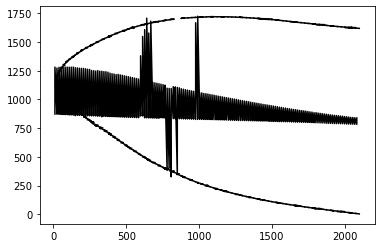

--- Process regress ran in: 0.44719s ---


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as scp
import math
import sys

from PIL import Image
from scipy.misc import derivative

from utils.other import perftimer
from utils.filereader import files_in_directory
from utils.filereader import load_file



# global variables
cut_left = 0
cut_right = 0
cut_up = 0
cut_down = 0
subgrid_size = 25


@perftimer
def imageVisualization(file, show_colorbar:bool = False, name:str = "") -> None:
    """
    visualization an image using plt.imshow()
    """
    plt.imshow(file)
    if show_colorbar:
        plt.colorbar()
    plt.show()


@perftimer
def loadRGBandBOOL(file: str, usepil: bool = False) -> list:
    """
    :param file: The file path name from the repository root of the image
    :param usepil: True or False value depending on the wish to use the Pil libary or not
    :return: A list containing the image array were every cell contains the rgb code of the pixel,
    the second item is an initialized boolean array with the size of the color array.
    """

    # generate file with methode of choice
    if usepil:
        image_colordata = Image.open(file)
    else:
        image_colordata = plt.imread(file)

    # intialize empty boolean array with the size of the color array
    file_bool = np.asarray(np.zeros((np.copy(image_colordata).shape[:2]), dtype=bool))
    return [np.asarray(image_colordata), file_bool]

@perftimer
def addcamber(array: np.ndarray) -> list:
    """
    :param array: array containing boolean values based on the location of the camber line.
    on locations where a camber line can be found the array item will have a value of 1, no camber is 0.
    note: the size of the array(after cropping(same crop func as contour)) is equal to the cropped array representing the contour.
    :return: x and y locations of camber points + addition of points to plot
    """
    points = np.argwhere(array == 1)
    x = []
    y = []
    for i in points:
        x.append(i[0])
        y.append(i[1])
    x = np.array(x)
    y = np.array(y)
    plt.plot(x,y,"k")
    return [x,y]


# Outdated function used for debugging
def plotBoolpoints(array: np.ndarray, line: list = None) -> None:

    points_x, points_y = addcamber(array)
    plt.scatter(points_x, points_y)
    if line:
        x = line[0]
        a = line[1]
        b = line[2]
        x_avg = line[3]
        y_avg = line[4]
        plt.plot(x, a*x + b)
        plt.plot(x_avg, y_avg, 'ro')
    plt.show()


def rotate(array: np.ndarray, amount: int = 1) -> np.ndarray:
    """
    :param array: A np.ndarray that is to be rotated
    :param amount: Amount of times the array should be flipped 90degrees (were + is CW)
    :return: Rotated array
    """
    return np.rot90(array, k=amount)


@perftimer
def cropimage(array_color: np.ndarray, array_bool: np.ndarray) -> tuple:
    """
    :param array_color: Color image array to be cropped
    :param array_bool: Boolean array to be cropped
    :return: cropped image(color and bool in a list) based on two anker point,
     found at the bottom left and top right part of the screen.
     The ankerpoints are based on locations were no critical data will be left
     after linear cropping.
    """

    # initialize global variables
    global cut_left
    global cut_right
    global cut_up
    global cut_down

    def ankerpoint2() -> tuple:
        """
        :return: Two anker points in a list/ tuple
        """
        for y in range(size[0] - 1, 3*(size[0]//5), -1):
            if np.any(array_bool[y, 250:size[1]//2]):
                break
        for x in range(0, size[1]//2):
            if np.any(array_bool[3*(size[0]//5):size[0],x]):
                break
        for y2 in range(0, 2*(size[0]//5)):
            if np.any(array_bool[y2,:]):
                break
        for x2 in range(size[1] - 1, 2*(size[1]//5), -1):
            if np.any(array_bool[2*(size[0]//5):size[0],x2]):
                break
        return y, x, y2, x2

    size = np.shape(array_bool)
    ankers = ankerpoint2()

    # save the amount that is going to be cropped on all sides
    cut_left = ankers[1] - 1
    cut_right = size[1] - ankers[3]
    cut_up = ankers[2]
    cut_down = size[0] - ankers[0]

    # crop both the color and boolean array
    out_array_color = array_color[ankers[2]:ankers[0]-1, ankers[1]:ankers[3]+1]
    out_array_bool = array_bool[ankers[2]:ankers[0]-1, ankers[1]:ankers[3]+1]

    return out_array_color, out_array_bool


@perftimer
def creategrid(array_bool: np.ndarray, usedict:bool = False):
    """
    :param array_bool: Cropped or non-cropped boolean array, to be devided into subgrids
    which are later to be used for linear/ or other global contour approximation.
    :param usedict: For debugging perpose, dump the array data as a dictionary.
    :return: A 4 dimensional array containing subgrids(of requested size) on each of the mxn elements.
    """

    # initialize global variable
    global subgrid_size

    def pad_with(vector, pad_width, iaxis, kwargs):
        """
        :param vector: 2 dimension array to be padded
        :param pad_width: Direction to be padded by requested amount
        :param iaxis: /
        :param kwargs: padder = some value <- the value wich is used to pad the array (0, False in this use case)
        :return: A padded array in the requested direction
        """
        pad_value = kwargs.get('padder', 0)
        vector[:pad_width[0]] = pad_value
        if pad_width[1] != 0:
            vector[-pad_width[1]:] = pad_value

    # Find the amount an array should be padded to allow for grid creation based on the requested subgrid size
    size = np.shape(array_bool)

    size_corectionY = subgrid_size - size[0] % subgrid_size
    size_corectionX = subgrid_size - size[1] % subgrid_size

    # Pad the array in vertical and or horizontal direction to allow for grid creation
    if size_corectionY != subgrid_size:
        array_bool = np.pad(array_bool, ((size_corectionY, 0), (0, 0)), pad_with, padder=0)
    if size_corectionX != subgrid_size:
        array_bool = np.pad(array_bool, ((0, 0), (0, size_corectionX)), pad_with, padder=0)

    # Initialize dump and subgrid array
    size = np.shape(array_bool)
    subgrids_dict = {}
    subgrids = []

    # Create and store the subgrids
    for i in range(0, size[0], subgrid_size):
        empty_1 = []
        for j in range(0, size[1], subgrid_size):
            subgrid = array_bool[i:i+subgrid_size, j:j+subgrid_size]
            empty_1.append(subgrid)
            if usedict:
                subgrid_loc = f"{i // subgrid_size}x{j // subgrid_size}"
                subgrids_dict[subgrid_loc] = subgrid
        subgrids.append(empty_1)
    subgrids = np.array(subgrids)
    if usedict:
        return subgrids, subgrids_dict
    return subgrids


@perftimer
def regress(array: np.ndarray) -> np.ndarray:
    """
    :param array: 4 dimensional array containing subgrids,
    using the subgrids the contour of the airfoil can be approximated using a linear approximation.
    linear approximation used: Least squares
    :return: Centroid locations of the least squares pieces [np.array([x-points]), np.array([x-points])].
    Pyplot containing the approximated airfoil contour
    """

    # initialize global variable
    global subgrid_size

    def genBoolXY(array: np.ndarray) -> list:
        """
        :param array: 2 dimensional boolean array (subgrid).
        :return: A list containing the location of the True values of the specified input array.
        The coordinates are defined from the top left, the x(vertical) and y(horizontal)
        are defined to plot the aifoil on its side.
        """

        points = np.argwhere(array == True)
        x = []
        y = []
        for i in points:
            x.append(i[0])
            y.append(i[1])
        x = np.array(x)
        y = np.array(y)
        return [x, y]

    def setupLS(array: np.ndarray, index: tuple = (0, 0)) -> list:
        """
        :param array: The boolean array(subgrid) of the airfoil LE contour on wich least squares should be performed.
        :param index: current index of subgrid to translate to the correct global location.
        :return: list with unique x values, slope and intercept found from least square,average x and y.
        A global plot of the approximated airfoil LE contour is also contructed in the meantime.
        """

        # initialize global variable
        global subgrid_size

        # get x and y coordinates of True points in array/subgrid
        x, y = genBoolXY(array)

        # Transform x and y to global position
        x += index[0]*subgrid_size
        y += index[1]*subgrid_size

        ##  plt.scatter(x, y) # plot contour points (DEBUG)

        # centroid of array/ subgrid of bool values where True has weight 1 and False 0
        x_avg = np.mean(x)
        y_avg = np.mean(y)

        # Least squares
        A = np.vstack([x, np.ones(len(x))]).T
        a, b = np.linalg.lstsq(A, y, rcond=None)[0]

        x = np.array(list(set(x)))

        plt.plot(x, a * x + b, "black")

        ## plt.plot(x_avg, y_avg, 'ro') # plot centroid points (DEBUG)

        return [x, a, b, x_avg, y_avg]

    size = np.shape(array)[0:2]

    # Initialize arrays containing subgrid values(Weight(amount of True over total items in array/subgrid),
    # slope, centroid) for the ful global contour
    weight = np.zeros(size)
    slope = np.zeros(size)
    centroidX = []
    centroidY = []

    # perform least squares for every subgrid in main global array
    for i in range(int(size[0])):
        for j in range(int(size[1])):
            loc_array = array[i,j]
            if np.count_nonzero(loc_array == True):
                ## some debugging code (DEBUG)
                ## if ok == 5 or ok == 10:
                    # imageVisualization(loc_array)
                    # plotBoolpoints(rotate(loc_array, amount=-1), line=setupLS(rotate(loc_array, amount=-1), index=(i,j), subgrid_size= subgrid_size))
                    # setupLS(rotate(loc_array, amount=-1), index=(i,j), subgrid_size= subgrid_size)
                    # plt.show()
                # Least square
                res = setupLS(rotate(loc_array, amount=0), index=(i, j))

                # data of all the subgrids
                weight[i, j] = np.count_nonzero(loc_array) / subgrid_size
                slope[i, j] = res[1]
                centroidX.append(res[3])
                centroidY.append(res[4])

    centroid = np.vstack((centroidX, centroidY))
    plt.show()
    return centroid


@perftimer
class DeflectionProfiles:
    """
    Deflection angles realtive to the chord line, the class contains two different methodes for finding the angles.
    methode 1 relies on the tip and the midpoint of the contour root points.
    methode 2 makes use of the camber line to identify the leading an trailing point
    for both methodes the angle is obtained using the arctangent of delta y / delta x.
    """

    def __init__(self, camberline, centroid):
        """
        :param camberline: list containing the x and y locations of the camber line points.
        [np.array([x-points]), np.array([y-points])]
        :param centroid: list containing the x and y locations of the centroids of the least squares methode.
        [np.array([x-points]), np.array([y-points])]
        """
        self.camberline = camberline
        self.cX = centroid[0,:]
        self.cY = centroid[1,:]
        self.tipX = np.min(self.cX)
        self.tipY = float(self.cY[np.where(self.cX == self.tipX)])
        self.rootY1 = np.min(self.cY)
        self.rootY2 = np.max(self.cY)
        self.rootX1 = float(self.cX[np.where(self.cY == self.rootY1)])
        self.rootX2 = float(self.cX[np.where(self.cY == self.rootY2)])
        self.rootmidpointX = np.abs(self.rootX2 + self.rootX1)/2
        self.rootmidpointY = np.abs(self.rootY2 + self.rootY1)/2
        self.dangle1 = 0
        self.dangle2 = 0
        self.model1()
        self.model2()

    def model1(self):
        """
        :return: Deflection angle using rootmidpoint and tip point
        """
        self.dangle1 = math.atan2(abs(self.rootmidpointY-self.tipY),
                                  abs(self.rootmidpointX-self.tipX)) * 180 / math.pi

    def model2(self):
        """
        :return: Deflection angle using the tip and trailing point of the camber line
        """
        self.dangle2 = math.atan2(abs(self.camberline[1][-1] - self.camberline[1][0]),
                                  abs(self.camberline[0][-1] - self.camberline[0][0])) * 180 / math.pi


    # for local gradient, but shouldn't be to important
    def model3(self):
        f = scp.interp1d(self.camberline[0], self.camberline[1], kind='linear')
        print(f.__dict__)
        # fprime = derivative(f, 1.0, dx=1e-6)
        plt.plot(self.camberline[0], f(self.camberline[0]))
        plt.show()

    def model4(self):
        pass

    def printsummary(self):
        """
        :return: summary of the deflection angles
        """
        print("---------- Deflection angles - summary ----------")
        print(f"model1: {self.dangle1} degrees")
        print(f"model1: {self.dangle2} degrees")


# -----------------
# Main calling code
# -----------------

# imageVisualization(a)
# imageVisualization(cropimage(a, a)[1])
# creategrid(np.array([[1,2],[2,3]]), np.array([[1,2],[2,3]]))
# creategrid(a,a, subgrid_size=4)
#
#
# images = files_in_directory("Images (BMP) - FOR IMAGE CALIBRATION ONLY", "bmp")
# image = loadRGBandBOOL(images[-1])
#
# imageVisualization(image[0])
# imageVisualization(image[1])


### Obtain loadstep data
img_bool_loc = files_in_directory("csv_bool", "csv")
img_bool_file1 = load_file(img_bool_loc[0], separator=",", skip_last=True)
img_bool_file2 = load_file(img_bool_loc[1], separator=",", skip_last=True)

# imageVisualization(img_bool_file)
img_bool_cropped_camber, img_bool_cropped = cropimage(np.array(np.asarray(img_bool_file2), dtype=bool), np.array(np.asarray(img_bool_file1), dtype=bool))
# imageVisualization(img_bool_cropped)
# imageVisualization(img_bool_cropped_camber)

camber_ = addcamber(img_bool_cropped_camber)
#plotBool(rotate(img_bool_cropped,3))
img_grid = creategrid(img_bool_cropped)
centroid_ = regress(img_grid)

# df1 = DeflectionProfiles(camber_, centroid_)
# print(df1.__dict__)


### Obtain target data
# img_bool_file_target1 = load_file(img_bool_loc[], separator=",", skip_last=True)
# img_bool_file_target2 = load_file(img_bool_loc[], separator=",", skip_last=True)
#
# img_bool_cropped_camber_target, img_bool_cropped_target = cropimage(np.array(np.asarray(img_bool_file_target2), dtype=bool), np.array(np.asarray(img_bool_file_target1), dtype=bool))
#
# camber_target_ = addcamber(img_bool_cropped_camber_target)
# img_grid_target = creategrid(img_bool_cropped_target)
# centroid_target_ = regress(img_grid_target)

# dft = DeflectionProfiles(camber_target_, centroid_target_)
# print(dft.__dict__)

# present results
# plt.show()

#deflection angle realtive to target (substract both data points)

# img_bool_file2 = load_file(img_bool_loc[0], separator=",", skip_last=True)
# img_bool_cropped2 = cropimage(np.array(np.asarray(img_bool_file2), dtype=bool), np.array(np.asarray(img_bool_file2), dtype=bool))[1]
#
# imageVisualization(img_bool_cropped2)

# imageVisualization(img_bool_cropped)
# points = np.argwhere(img_bool_cropped == True)
#
# print(*zip(*points))
# plt.scatter(*zip(*points))
# plt.show()


# sometesting = load_file(img_bool_loc[3], separator=",", skip_last= False)
# sometesting = np.asarray(sometesting)
# for level in range(np.shape(sometesting)[0]):
#     plt.scatter(sometesting[:,2], sometesting[:,1])
# plt.show()

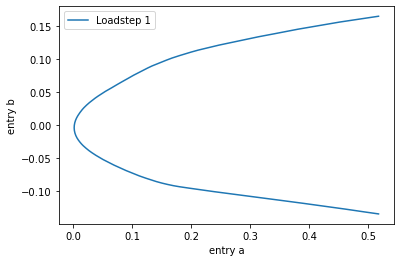

In [3]:
plt.plot(loadstep1_disp[:, 1] + loadstep1_disp[:, 4], loadstep1_disp[:, 2] + loadstep1_disp[:, 5],
            label="Loadstep 1")
plt.xlabel('entry a')
plt.ylabel('entry b')
plt.legend()